In [1]:
!nvidia-smi

Mon Dec 23 20:53:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Install libraries

In [2]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax jsonlines ftfy wandb
!pip install -U tqdm
!pip install git+https://github.com/deepmind/optax.git

In [3]:
%%capture
!git clone https://github.com/arampacha/CLIP-rsicd

In [4]:
import sys
sys.path += ['CLIP-rsicd']

## Imports

In [5]:
import jax
try:
    # This will raise an exception if no TPU is found
    jax.devices('cuda')[0]
    half_precision_dtype = "bfloat16"
except IndexError:
    half_precision_dtype = "float16"
    print("No TPU detected, using float16")
device_count = jax.device_count()
print(device_count)

1


In [6]:
import logging
import math
import os
import sys
import time
from dataclasses import dataclass, field
from pathlib import Path
from typing import Callable, Optional, List
import json
import jsonlines
import shutil
import numpy as np
import torch

from flax import training
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import optax
import transformers
from flax import jax_utils, traverse_util
from flax.jax_utils import unreplicate
from flax.training import train_state
from flax.training.common_utils import get_metrics, onehot, shard, shard_prng_key
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
from flax.serialization import to_bytes, from_bytes
from transformers import (
    CONFIG_MAPPING,
    AutoConfig,
    FlaxCLIPModel,
    CLIPProcessor,
    CLIPTokenizer,
    TrainingArguments,
    is_tensorboard_available,
    IntervalStrategy

)
from transformers.testing_utils import CaptureLogger

from importlib.util import find_spec

logger = logging.getLogger(__name__)

In [7]:
from utils.data import ImageTextDataset, Transform

## Data

In this notebook we will be using [RSICD dataset](). A copy of this dataset is shared by the authors on google drive. To use it one can simply add a shrtcut to own gdrive. In my case it's `RSICD` folder.

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [9]:
path = Path(root_dir + 'RSICD/')

In [10]:
%%capture
!unrar x gdrive/MyDrive/RSICD/RSICD_images.rar ./data/

In [11]:
!mv /content/data/RSICD_images/ /content/data/rsicd_images

We'll be using augmented captions for the images. The files containing those are available in our [github repo]().

In [12]:
%%capture
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_train_rsicd.jsonl
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_valid_rsicd.jsonl
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_test_rsicd.jsonl

Each line in the `jsonl` file has two fields: `filename` and `captions`:

In [13]:
with jsonlines.open("/content/data/textaug_valid_rsicd.jsonl", "r") as reader:
    line = next(iter(reader))
print(f"filename: {line['filename']}\n")
print("captions:")
for i, caption in enumerate(line["captions"]):
    print(f"{i+1}) {caption}")

filename: rsicd_images/airport_61.jpg

captions:
1) the asphalted and airport runways divide the field into several rounded rectangles arranged next to which buildings and a road are located.
2) the tarmac and airport runways divide the field into several orderly arranged rounded rectangles  next to which is buildings and a road .
3) a brown ground divided by the grey runway .
4) we can see a simple termial building and an apron connceted with runways .
5) some building with a parking lot are near an airport with several runways .


## Training arguments

In [14]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    dtype: Optional[str] = field(
        default="float32",
        metadata={
            "help": "Floating-point format in which the model weights should be initialized and trained. Choose one of `[float32, float16, bfloat16]`."
        },
    )
    save_optimizer: Optional[bool] = field(
        default=True,
        metadata={"help": "Whether to store full train state including optimizer."},
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    data_dir: Optional[str] = field(
        default=None, metadata={"help": "Path to local folder containing data files."}
    )
    train_file: Optional[str] = field(
        default=None, metadata={"help": "The input training data file (a jsonlines file)."}
    )
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file (a jsonlines file)."},
    )
    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    block_size: Optional[int] = field(
        default=None,
        metadata={
            "help": "Optional input sequence length after tokenization. "
            "The training dataset will be truncated in block of this size for training. "
            "Default to the model max input length for single sentence inputs (take into account special tokens)."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    text_column_name: Optional[str] = field(
            default='text',
            metadata={"help": "Column containing main text data."},
    )
    augment_images: Optional[bool] = field(
        default=True,
        metadata={ "help": "Augment input training images" }
    )
    augment_captions: Optional[bool] = field(
        default=True,
        metadata={ "help": "Augment input training images" }
    )
    captions_per_image: Optional[int] = field(
        default=5,
        metadata={"help": "Number of captions per image to use when creating train dataset."},
    )

    def __post_init__(self):
        if self.dataset_name is None and self.train_file is None and self.validation_file is None:
            raise ValueError("Need either a dataset name or a training/validation file.")
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in ["csv", "json", "txt", "jsonl"], "`train_file` should be a csv, a json or a txt file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in ["csv", "json", "txt", "jsonl"], "`validation_file` should be a csv, a json or a txt file."


@dataclass
class ImageAugmentationArguments:
    """
    Arguments for image augmentations configuration
    """
    random_horizontal_flip: Optional[float] = field(
        default=0.5,
        metadata={ "help": "Probability of applying random horizontal flip" }
    )
    random_vertical_flip: Optional[float] = field(
        default=0.5,
        metadata={ "help": "Probability of applying random vartical flip" }
    )


In [15]:
training_args = TrainingArguments(
    output_dir = "./tmp/model2",
    overwrite_output_dir = False,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "steps",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    gradient_accumulation_steps = 8,
    learning_rate = 5e-05,  #1.2254895409569144e-06,
    weight_decay = 0.1,
    adam_beta1 = 0.9,
    adam_beta2 = 0.98,
    adam_epsilon = 1e-06,
    max_grad_norm = 1.0,
    num_train_epochs = 30,
    max_steps = -1,
    lr_scheduler_type = "linear",
    warmup_ratio = 0, #0.2,  #0,
    # warmup_steps = 0,
    logging_first_step = False,
    logging_steps = 50,
    save_strategy = "epoch",
    seed = 42,
    dataloader_drop_last = True,
    eval_steps = 200,
    run_name = None,
    adafactor = False,
    report_to = "all",
    skip_memory_metrics = True,
    resume_from_checkpoint = None,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1573: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
model_args = ModelArguments(
    model_name_or_path = "openai/clip-vit-base-patch32",
    dtype = half_precision_dtype,
    save_optimizer = False,
)

In [17]:
data_args = DataTrainingArguments(
    dataset_name = None,
    data_dir = "./data",
    train_file = "/content/data/textaug_train_rsicd.jsonl",
    validation_file = "/content/data/textaug_valid_rsicd.jsonl",
    max_train_samples = None,
    max_eval_samples = None,
    overwrite_cache = False,
    validation_split_percentage = 5,
    preprocessing_num_workers = 2,
    augment_images = True,
    augment_captions = True,
    captions_per_image = 5,
)

augmentation_args = ImageAugmentationArguments()

Some utility functions for training:

In [18]:
class TrainState(train_state.TrainState):
    dropout_rng: jnp.ndarray

    def replicate(self):
        return jax_utils.replicate(self).replace(dropout_rng=shard_prng_key(self.dropout_rng))


def write_train_metric(summary_writer, train_metrics, train_time, step):
    summary_writer.scalar("train_time", train_time, step)

    train_metrics = get_metrics(train_metrics)
    for key, vals in train_metrics.items():
        tag = f"train_{key}"
        for i, val in enumerate(vals):
            summary_writer.scalar(tag, val, step - len(vals) + i + 1)


def write_eval_metric(summary_writer, eval_metrics, step):
    for metric_name, value in eval_metrics.items():
        summary_writer.scalar(f"eval_{metric_name}", value, step)


def create_learning_rate_fn(
    train_ds_size: int, train_batch_size: int, num_train_epochs: int, warmup_ratio: float, learning_rate: float
) -> Callable[[int], jnp.array]:
    """Returns a linear warmup, linear_decay learning rate function."""
    steps_per_epoch = train_ds_size // train_batch_size
    num_train_steps = steps_per_epoch * num_train_epochs
    num_warmup_steps = int(num_train_steps * warmup_ratio)
    warmup_fn = optax.linear_schedule(init_value=0.0, end_value=learning_rate, transition_steps=num_warmup_steps)
    decay_fn = optax.linear_schedule(
        init_value=learning_rate, end_value=0, transition_steps=num_train_steps - num_warmup_steps
    )
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, decay_fn], boundaries=[num_warmup_steps])
    return schedule_fn

# utils
def mb_item(x):
    return x.item() if hasattr(x, "item") else x

def make_batch(samples):
    batch = {k:jnp.array(v) for k,v in samples.items()}
    return batch


## Training

In [19]:
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [20]:
# Load pretrained model and tokenizer

# Distributed training:
# The .from_pretrained methods guarantee that only one local process can concurrently
# download model & vocab.
if model_args.config_name:
    config = AutoConfig.from_pretrained(model_args.config_name, cache_dir=model_args.cache_dir)
elif model_args.model_name_or_path:
    config = AutoConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
else:
    config = CONFIG_MAPPING[model_args.model_type]()
    logger.warning("You are instantiating a new config instance from scratch.")

processor = CLIPProcessor.from_pretrained(model_args.model_name_or_path)
tokenizer = processor.tokenizer
if model_args.model_name_or_path:
    model = FlaxCLIPModel.from_pretrained(
        model_args.model_name_or_path, config=config, seed=training_args.seed, dtype=getattr(jnp, model_args.dtype)
    )
else:
    model = FlaxCLIPModel.from_config(
        config, seed=training_args.seed, dtype=getattr(jnp, model_args.dtype)
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [21]:
config = model.config
# Initialize torchvision transforms and jit them for faster processing
preprocess = Transform(config.vision_config.image_size, data_args.augment_images, augmentation_args)
preprocess = torch.jit.script(preprocess)

eval_preprocess = Transform(config.vision_config.image_size, False, augmentation_args)
eval_preprocess = torch.jit.script(eval_preprocess)

# Initialize the image-text dataset
train_dataset = ImageTextDataset(
    data_args.data_dir,
    "train",
    captions_per_image=data_args.captions_per_image,
    augment_captions=data_args.augment_captions,
    transform=preprocess,
)

eval_dataset = ImageTextDataset(
    data_args.data_dir,
    "valid",
    captions_per_image=1,
    transform=eval_preprocess,
)

# Enable tensorboard only on the master node
has_tensorboard = is_tensorboard_available()
if has_tensorboard and jax.process_index() == 0:
    try:
        from flax.metrics.tensorboard import SummaryWriter

        summary_writer = SummaryWriter(log_dir=Path(training_args.output_dir))
    except ImportError as ie:
        has_tensorboard = False
        logger.warning(
            f"Unable to display metrics through TensorBoard because some package are not installed: {ie}"
        )
else:
    logger.warning(
        "Unable to display metrics through TensorBoard because the package is not installed: "
        "Please run pip install tensorboard to enable."
    )

# Use collate function to tokenizer the text and convert the processed images to numpy
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples]).numpy()
    captions = [example[1] for example in examples]
    inputs = tokenizer(captions, max_length=32, padding="max_length", return_tensors="np", truncation=True)

    batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }

    return batch

# Store some constant
num_epochs = int(training_args.num_train_epochs)
train_batch_size = int(training_args.per_device_train_batch_size) * jax.device_count() * training_args.gradient_accumulation_steps
eval_batch_size = int(training_args.per_device_eval_batch_size) * jax.device_count()
steps_per_epoch = len(train_dataset) // train_batch_size
total_train_steps = steps_per_epoch * num_epochs

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    #num_workers=data_args.preprocessing_num_workers,
    num_workers=0,  # Set num_workers to 0
    persistent_workers=False,
    drop_last=True,
    collate_fn=collate_fn,
)

eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    #num_workers=data_args.preprocessing_num_workers,
    num_workers=0,  # Set num_workers to 0
    persistent_workers=False,
    drop_last=True,
    collate_fn=collate_fn,
)


1 input files for train split found
1 input files for valid split found


In [22]:
# enable wandb tracking
has_wandb = find_spec("wandb") is not None
if jax.process_index() == 0 and has_wandb and ("wandb" in training_args.report_to):
    try:
        import wandb
        if training_args.run_name is None:
            run_name = training_args.output_dir.split("/")[-1]
        else:
            run_name = training_args.run_name
        wandb.init(
            name=run_name,
            entity="wandb",
            project="hf-flax-clip-rsicd",
            sync_tensorboard=True
        )
        wandb.config.update(training_args)
        wandb.config.update(model_args)
        wandb.config.update(data_args)
    except ImportError as e:
        print(e)
        has_wandb = False

# Initialize our training
rng = jax.random.PRNGKey(training_args.seed)
rng, dropout_rng = jax.random.split(rng)

# Create learning rate schedule
linear_decay_lr_schedule_fn = create_learning_rate_fn(
    len(train_dataset),
    train_batch_size,
    training_args.num_train_epochs,
    training_args.warmup_ratio,
    training_args.learning_rate,
)

# We use Optax's "masking" functionality to not apply weight decay
# to bias and LayerNorm scale parameters. decay_mask_fn returns a
# mask boolean with the same structure as the parameters.
# The mask is True for parameters that should be decayed.
# Note that this mask is specifically adapted for FlaxGPT2.
# For other models, one should correct the layer norm parameter naming
# accordingly.
def decay_mask_fn(params):
    flat_params = traverse_util.flatten_dict(params)
    flat_mask = {
        path: (path[-1] != "bias" and path[-2:] not in [("ln_1", "scale"), ("ln_2", "scale"), ("ln_f", "scale")])
        for path in flat_params
    }
    return traverse_util.unflatten_dict(flat_mask)

# create optimizer
if training_args.adafactor:
    # We use the default parameters here to initialize adafactor,
    # For more details about the parameters please check https://github.com/deepmind/optax/blob/ed02befef9bf81cbbf236be3d2b0e032e9ed4a40/optax/_src/alias.py#L74
    optimizer = optax.adafactor(
        learning_rate=linear_decay_lr_schedule_fn,
    )
else:
    optimizer = optax.adamw(
        learning_rate=linear_decay_lr_schedule_fn,
        b1=training_args.adam_beta1,
        b2=training_args.adam_beta2,
        eps=training_args.adam_epsilon,
        weight_decay=training_args.weight_decay,
        mask=decay_mask_fn,
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(training_args.max_grad_norm),
        optimizer
    )
if training_args.gradient_accumulation_steps > 1:
    optimizer = optax.MultiSteps(optimizer, training_args.gradient_accumulation_steps)
grad_accum_steps = training_args.gradient_accumulation_steps

# Setup train state
state = TrainState.create(apply_fn=model.__call__, params=model.params, tx=optimizer, dropout_rng=dropout_rng)

if training_args.resume_from_checkpoint:
    state = restore_checkpoint(training_args.resume_from_checkpoint, state)
    resume_step = mb_item(state.step)
else:
    resume_step = 0

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
def cross_entropy(logits, axis):
    logprobs = jax.nn.log_softmax(logits, axis=axis)
    nll = jnp.diag(logprobs)
    ce = -jnp.mean(nll)
    return ce

def clip_loss(similarity):
    loss = (cross_entropy(similarity, axis=0) + cross_entropy(similarity, axis=1)) / 2
    return loss

# Define gradient update step fn
def train_step(state, batch):
    dropout_rng, new_dropout_rng = jax.random.split(state.dropout_rng)

    def compute_loss(params):
        logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]
        loss = clip_loss(logits)
        return loss

    grad_fn = jax.value_and_grad(compute_loss)
    loss, grad = grad_fn(state.params)
    grad = jax.lax.pmean(grad, "batch")

    new_state = state.apply_gradients(grads=grad, dropout_rng=new_dropout_rng)

    metrics = {"loss": loss, "learning_rate": linear_decay_lr_schedule_fn(state.step // grad_accum_steps)}
    metrics = jax.lax.pmean(metrics, axis_name="batch")

    return new_state, metrics

# Define eval fn
def eval_step(params, batch):
    logits = model(**batch, params=params, train=False)[0]
    loss = clip_loss(logits)

    # summarize metrics
    metrics = {"loss": loss}
    metrics = jax.lax.pmean(metrics, axis_name="batch")
    return metrics

# Create parallel version of the train and eval step
p_train_step = jax.pmap(train_step, "batch", donate_argnums=(0,))
p_eval_step = jax.pmap(eval_step, "batch")

# Replicate the train state on each device
state = state.replicate()

In [24]:
logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_epochs}")
logger.info(f"  Instantaneous batch size per device = {training_args.per_device_train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed and grad_accum) = {train_batch_size}")
logger.info(f"  Total optimization steps = {total_train_steps}")

epoch_losses_train = []
epoch_losses_eval = []

if not training_args.skip_memory_metrics:
    server = jax.profiler.start_server(9999)

train_time = 0
train_metrics = []
epochs = tqdm(range(num_epochs), desc=f"Epoch ... (1/{num_epochs})", position=0)
for epoch in epochs:
    # ======================== Training ================================
    train_start = time.time()

    # Create sampling rng
    rng, input_rng = jax.random.split(rng)

    # Generate an epoch by shuffling sampling indices from the train dataset
    steps_per_epoch = len(train_dataset) // train_batch_size
    # train
    steps_trained_progress_bar = tqdm(range(steps_per_epoch), desc="Training...", position=1,
                                        leave=False, initial=(resume_step // grad_accum_steps))
    for step, batch in enumerate(train_loader):
        cur_step = epoch * (len(train_dataset) // train_batch_size) + step
        # skip to the step from which we are resuming
        if cur_step < resume_step:
            continue

        batch = shard(make_batch(batch))

        state, train_metric = p_train_step(state, batch)
        train_metrics.append(train_metric)
        if step % grad_accum_steps == 0:
            steps_trained_progress_bar.update(1)

        if cur_step % (training_args.logging_steps * grad_accum_steps)== 0 and cur_step > 0:
            # Save metrics
            train_metric = unreplicate(train_metric)
            train_time += time.time() - train_start
            if has_tensorboard and jax.process_index() == 0:
                write_train_metric(summary_writer, train_metrics, train_time, cur_step)
            if has_wandb and jax.process_index() == 0 and ("wandb" in training_args.report_to):
                # TODO: add accumulation of metrics
                _metrics = {k if k=="learning_rate" else f"train_{k}":mb_item(v.mean()) for k, v in train_metric.items()}
                wandb.log({"training_step":cur_step, **_metrics}, commit=True)

            epochs.write(
                f"Step... ({cur_step} | Loss: {train_metric['loss'].mean()}, Learning Rate: {train_metric['learning_rate'].mean()})"
            )

            train_metrics = []

    # Accumulate training loss for the epoch
    total_epoch_loss = 0
    for train_metric in train_metrics:
        total_epoch_loss += train_metric['loss'].mean()

    # Calculate average epoch loss
    average_epoch_loss = total_epoch_loss / len(train_metrics)
    epoch_losses_train.append(average_epoch_loss)

    if True:
        # ======================== Evaluating ==============================
        eval_metrics = []
        eval_steps = len(eval_dataset) // eval_batch_size
        for batch in tqdm(eval_loader, desc="Evaluating...", position=2, leave=False):
            # Model forward
            batch = shard(make_batch(batch))
            metrics = p_eval_step(state.params, batch)
            eval_metrics.append(metrics)

        # normalize eval metrics
        eval_metrics = get_metrics(eval_metrics)
        eval_metrics = jax.tree.map(jnp.mean, eval_metrics)

        # Print metrics and update progress bar
        desc = f"Step... ({cur_step} | Eval Loss: {eval_metrics['loss']})"
        epochs.write(desc)
        epochs.desc = desc

        # Save metrics
        if has_tensorboard and jax.process_index() == 0:
            # cur_step = epoch * (len(train_dataset) // train_batch_size)
            write_eval_metric(summary_writer, eval_metrics, cur_step)
        if has_wandb and jax.process_index() == 0 and ("wandb" in training_args.report_to):
            _metrics = {f"eval_{k}":mb_item(v) for k, v in eval_metrics.items()}
            wandb.log({"eval_step":cur_step, **_metrics})

        # Store eval loss for the epoch:
        epoch_losses_eval.append(eval_metrics['loss'])  # Append eval_metrics['loss'] to epoch_losses_eval

    # save checkpoint after each epoch
    if jax.process_index() == 0:
        save_dir = f"{training_args.output_dir}/ckpt-{epoch}"
        model.save_pretrained(
            save_dir,
            params=unreplicate(state.params),
            push_to_hub=False, # training_args.push_to_hub, # we don't push intermediate steps
            commit_message=f"Saving weights and logs at epoch {epoch}",
            repo_name_or_path=training_args.output_dir
        )
        if model_args.save_optimizer:
            save_checkpoint(training_args.output_dir, unreplicate(state), cur_step, keep=training_args.save_total_limit, overwrite=True)
        if training_args.save_total_limit is not None:
            rotate_checkpoints(training_args.output_dir, training_args.save_total_limit)


Epoch ... (1/30):   0%|          | 0/30 [00:00<?, ?it/s]

Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (169 | Eval Loss: 3.388152599334717)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (339 | Eval Loss: 3.2785253524780273)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Step... (400 | Loss: 2.4444355964660645, Learning Rate: 1.2134750022596563e-06)


Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (509 | Eval Loss: 3.240161180496216)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (679 | Eval Loss: 3.2372496128082275)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Step... (800 | Loss: 2.145759105682373, Learning Rate: 1.2014603498755605e-06)


Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (849 | Eval Loss: 3.226867198944092)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (1019 | Eval Loss: 3.2192070484161377)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (1189 | Eval Loss: 3.226469039916992)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Step... (1200 | Loss: 1.9391083717346191, Learning Rate: 1.1894456974914647e-06)


Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (1359 | Eval Loss: 3.238323211669922)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/34 [00:00<?, ?it/s]

Step... (1529 | Eval Loss: 3.252694606781006)


Training...:   0%|          | 0/170 [00:00<?, ?it/s]

KeyboardInterrupt: 

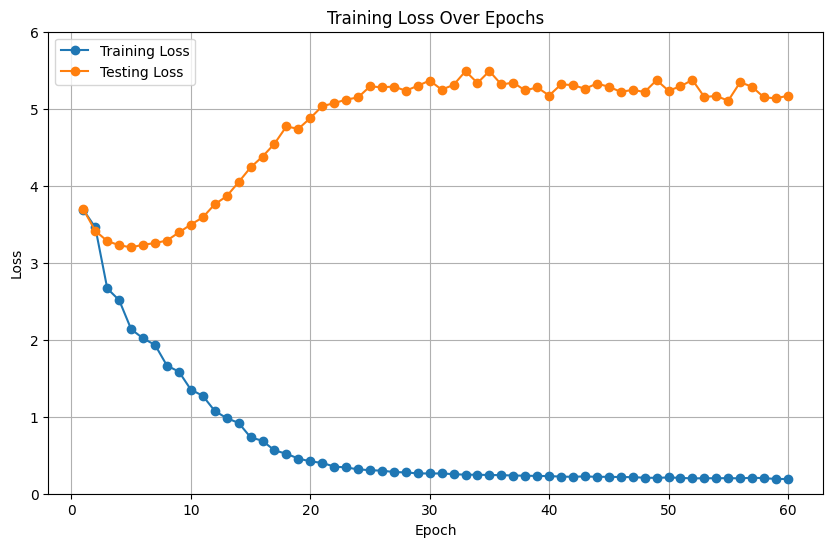

Training complete.


In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 60 + 1), epoch_losses_train, marker='o', label='Training Loss')
plt.plot(range(1, 60 + 1), epoch_losses_eval, marker='o', label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 6)
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

print("Training complete.")

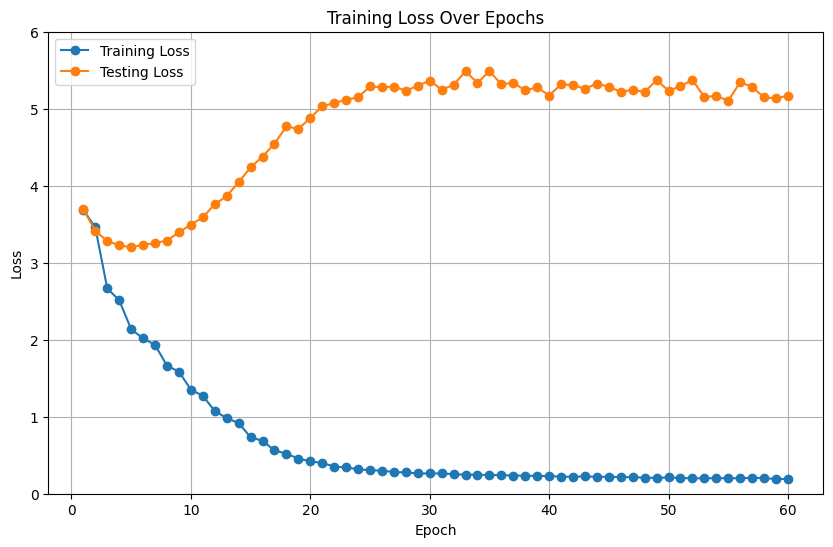

In [24]:
from transformers import FlaxCLIPModel, CLIPProcessor

model_name_or_path = "/content/gdrive/MyDrive/RSICD/savepoints/ckpt-5"  # Replace with your checkpoint path
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = FlaxCLIPModel.from_pretrained(model_name_or_path)

In [25]:
load_model=model

In [28]:
import torch
from tqdm import tqdm

# Initialize empty lists to store embeddings
text_embeddings = []
img_embeddings = []

# Disable dropout during inference
load_model.config.dropout_rate = 0.0

# Function to get text embeddings
def get_text_embeddings(texts):
  inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="np") # Changed to "np"
  with torch.no_grad():
    # Convert the NumPy array to a JAX array
    inputs = {k: jax.numpy.array(v) for k, v in inputs.items()}
    text_outputs = load_model.get_text_features(**inputs)
  # Convert the JAX array back to a NumPy array
  text_outputs_np = np.array(text_outputs)
  return text_outputs_np

# Function to get image embeddings
def get_image_embeddings(image):
  inputs = processor(images=[image], return_tensors="np") # Change return_tensors to "np"
  with torch.no_grad():
    # Convert the NumPy array to a JAX array
    inputs["pixel_values"] = jax.numpy.array(inputs["pixel_values"])
    image_outputs = load_model.get_image_features(**inputs)  # Now passing a JAX array
  return image_outputs

# Loop through the dataset and get embeddings for each text and image
for example in tqdm(eval_dataset):
  image, texts = example

  # Convert the image to a NumPy array
  image_np = image.cpu().numpy()

  # Normalize and clip the image data
  image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
  image_np = np.clip(image_np, 0, 1)

  # Get image embeddings
  image_embedding = get_image_embeddings(image_np)  # Call get_image_embeddings
  # Convert the JAX array to a NumPy array
  image_embedding_np = np.array(image_embedding)  # Convert to NumPy array
  img_embeddings.append(image_embedding_np)  # Append NumPy array to the list

  # Get text embeddings for all captions of the image
  text_embedding = get_text_embeddings(texts)
  text_embeddings.extend(text_embedding)  # Extend the list with the batch

100%|██████████| 1094/1094 [16:46<00:00,  1.09it/s]


In [42]:
import torch
from tqdm import tqdm

# Initialize empty lists to store embeddings
text_embeddings_train = []
img_embeddings = []

# Disable dropout during inference
load_model.config.dropout_rate = 0.0

# Function to get text embeddings
def get_text_embeddings(texts):
  inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="np") # Changed to "np"
  with torch.no_grad():
    # Convert the NumPy array to a JAX array
    inputs = {k: jax.numpy.array(v) for k, v in inputs.items()}
    text_outputs = load_model.get_text_features(**inputs)
  # Convert the JAX array back to a NumPy array
  text_outputs_np = np.array(text_outputs)
  return text_outputs_np

# Function to get image embeddings
def get_image_embeddings(image):
  inputs = processor(images=image, return_tensors="np") # Change return_tensors to "np"
  with torch.no_grad():
    # Convert the NumPy array to a JAX array
    inputs["pixel_values"] = jax.numpy.array(inputs["pixel_values"])
    image_outputs = load_model.get_image_features(**inputs)  # Now passing a JAX array
  return image_outputs

# Pre-process images outside the loop
images_list = []
texts_list = []
for example in train_dataset:
    image, texts = example
    image_np = image.cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = np.clip(image_np, 0, 1)
    images_list.append(image_np)
    texts_list.extend(texts)

all_texts = [text for example in train_dataset for text in example[1]] # Get all captions
    tokenized_texts = tokenizer(
        all_texts,
        padding=True,
        truncation=True,
        return_tensors="np"
    )

# Process image embeddings in batches
batch_size = 32  # Adjust as needed
for i in tqdm(range(0, len(images_list), batch_size)):
    image_batch = images_list[i : i + batch_size]
    img_embeddings.extend(get_image_embeddings(image_batch))

# Process text embeddings in batches (if needed)
batch_size_text = 32  # Adjust as needed
for i in tqdm(range(0, len(texts_list), batch_size_text)):
    batch_inputs = {k: v[i : i + batch_size] for k, v in inputs.items()}
    text_batch = texts_list[i : i + batch_size_text]
    text_embeddings_train.extend(get_text_embeddings(text_batch))

  7%|▋         | 1434/20026 [10:56<2:21:53,  2.18it/s]


KeyboardInterrupt: 

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape embeddings for cosine similarity calculation
img_embeddings_reshaped = np.array(img_embeddings).reshape(len(img_embeddings), -1)
text_embeddings_reshaped = np.array(text_embeddings).reshape(len(text_embeddings), -1)

# Calculate cosine similarity
similarities = cosine_similarity(img_embeddings_reshaped, text_embeddings_reshaped)

# Calculate average cosine similarity
average_similarity = np.mean(similarities)

print(f"Average Cosine Similarity: {average_similarity}")

Average Cosine Similarity: 0.1938818246126175


In [48]:
def compute_dot_product(image_embeddings, text_embeddings):
  """
  Computes the dot product between image and text embeddings.

  Args:
      image_embeddings: A list of PyTorch tensors representing image embeddings.
      text_embeddings: A list of PyTorch tensors representing text embeddings.

  Returns:
      A NumPy array representing the similarity matrix.
  """

  # Convert lists of tensors to a single tensor with shape [num_samples, embedding_dim]
  image_embeddings = torch.stack(image_embeddings)  # Stack PyTorch tensors
  text_embeddings = torch.stack(text_embeddings)  # Stack PyTorch tensors

  # Ensure tensors are on the same device
  device = image_embeddings.device
  text_embeddings = text_embeddings.to(device)

  print(text_embeddings.shape) #outputs torch.Size([779, 1, 512])
  print(image_embeddings.shape) #outputs torch.Size([779, 1, 512])

  image_embeddings = image_embeddings.squeeze(1)
  text_embeddings = text_embeddings.squeeze(1)

  print(text_embeddings.shape) #outputs torch.Size([779, 1, 512])
  print(image_embeddings.shape) #outputs torch.Size([779, 1, 512])

  text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
  image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

  similarity = text_embeddings.cpu().numpy() @ image_embeddings.cpu().numpy().T

  return similarity

In [49]:
sliceofdata=99

img_embeddings_tensor = [torch.from_numpy(np.array(img)) for img in img_embeddings][89:sliceofdata]
text_embeddings_tensor = [torch.from_numpy(np.array(text)) for text in text_embeddings][89:sliceofdata]

dot_products = compute_dot_product(img_embeddings_tensor, text_embeddings_tensor)

torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
